# 0) При реализации алгоритма разрешается использовать только библиотеки из requierments.txt

В него входит:
1. jupyter - библиотека для показа ноутбуков
2. numpy - библиотека для вычислений
3. matplotlib - библиотека для визуализации

## Установка 
1. Устанавливаем python3 и virtualenv
2. создаем окружение virtualenv --no-site-packages  lin_prog
3. активируем окружение source activate lin_prog
4. устанавливаем зависимости pip install -r requirements.txt
5. запускаем jupyter и начинаем работать jupyter notebook

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашему функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.3 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


### Дополнительная часть  (0.8 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)




In [37]:
import numpy as np
# Не печатать в лог сообщения о делении на ноль, ибо так и должно быть
np.seterr(divide='ignore', invalid='ignore')
import logging as log
import sys
log.basicConfig(level=log.DEBUG, format='>%(message)s', stream=sys.stdout)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

epsilon=0.0000001
def float_equal(a, b):
    return abs(a-b)<epsilon

#TODO: у задач с отрицательными бэшками проверить корректность значения целевой функции.

In [303]:
class SP:
    def __init__(self, A, b, c, c_old=None):
        self.A = A
        b = b.reshape((-1, 1)).astype(np.float64)
        self.b = b
        self.c = c
        
        self.n = n = A.shape[0]
        self.m = m = A.shape[1]
        #log.info('n=%s, m=%s'%(n, m))

        self.basis = np.array(list(range(0, n)))
        self.nonbasis = np.array(list(range(n, n+m)))
        #log.debug("basis %s, nonbasis %s"%(self.basis, self.nonbasis))
        
        # Сделаем симплекс-таблицу.
        self.ST = np.block([[A,  b], 
                           [-c, 0]]).astype(np.float64)
        #log.info('%s'%self.ST)
        if c_old is None:
            self.c_old = None
        else:
            self.c_old = c_old
    
    def from_ST(self, ST, basis, nonbasis):
        self.ST = ST
    
    def get_solution(self):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        x = np.zeros(m)
        w = np.zeros(n)
        for i in range(0, n):
            if 0<=basis[i]<n:
                w[basis[i]] = ST[:,-1][i]
            if basis[i]>=n:
                x[basis[i]-n] = ST[:,-1][i]
        log.info('x=%s, w=%s', x, w)
        # TODO WAT???????????????????????????????????????? why self.b.reshape(1,-1)[0]?
        #if (self.A@x > self.b.reshape(1,-1)[0]).any() or (x < 0).any():
        #    raise Exception('Solution is infeasible')
        return x, w
    
    def __get_variables(self, method):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        if method=='init_auxilary':
            if (ST[:, -1][:-1] > 0).all():
                raise Exception('Problem is unbounded')
            #########i = np.argmin(ST[:, -1][:-1])
            i = np.argmin(ST[:, -1][:-1]) # "наиболее недопустимая" строчка.
            j = m-1 # т. е. всегда добавленная переменная
            log.info('j=%s'%j)
            log.info('i=%s'%i)
            return i, j
        if method=='largest_coef':
            j = np.argmin(ST[-1][:-1])
        elif method=='blend':
            #j = np.argmin(np.ma.array(nonbasis, mask=(ST[-1][:-1]>=-epsilon)))
            #j = nonbasis[(ST[-1][:-1]<0)][0]
            #j = np.where(ST[-1][:-1]<0+epsilon)[0][0]
            ma = np.ma.masked_where(ST[-1, :-1] >= -epsilon, ST[-1, :-1])
            if ma.count() == 0:
                raise Exception("Something")
            #j = np.where(ma.mask == False)[0][0]
            j = np.argmin(ma)
        elif method=='lexical':
            j = np.argmin(ST[-1][:-1]) # любой
        else:
            raise Exception('Unknown method')
        
        ma = np.ma.masked_where(ST[:-1, j] <= epsilon, ST[:-1, j])
        if (ma.count() == 0):
            raise Exception('Problem is unbounded')
        mb = np.ma.masked_where(ST[:-1, j] <= epsilon, ST[:-1, -1])
        
        ratios = abs(mb/ma)
        log.info('j=%s'%j)
        #ratios = ST[:, -1][:-1]/ST[:, j][:-1]
        log.debug('ratios %s'%ratios)
        if (ratios<0).all():
            raise Exception('Problem is unbounded')
        i = np.where(ratios == ratios.min())[0][0] #worked
        
#         ma = np.ma.masked_where(T[:-k, pivcol] <= tol, T[:-k, pivcol], copy=False)
#     if ma.count() == 0:
#         return False, np.nan
#     mb = np.ma.masked_where(T[:-k, pivcol] <= tol, T[:-k, -1], copy=False)
#     q = mb / ma
# return True, np.ma.where(q == q.min())[0][0]
        
        #i = np.argmin(np.ma.array(ratios, mask=(ratios<0+epsilon)))
        
        # Если у нас есть неоднозначность выбора
        if np.count_nonzero(float_equal(ratios,  ratios[i]))>1:
            print('LLLLLLLLLLLLLLLLLLLLLLLLLL')
            if method=='lexical':
                # Делим каждую строчку на элемент, стоящий в столбце j
                ratios = ST[:-1] / ST[:-1, j].reshape(-1,1)
                print(ratios, ST[:, j].reshape(-1,1))
                print(ratios, ratios[:, j]<0)
                # Маскируем строчки, у которых коэффициент отрицательный и те, которые не конфликтуют
                array_mask = np.zeros_like(ratios)
                array_mask[ratios[:, j]<0] = 0
                array_mask[ratios != i] = 1
                print(array_mask)
                #arr = np.ma.mask_rows(np.ma.array(ratios[:-1], mask=(ratios[:-1, j]<0)))
                srt = np.lexsort(np.ma.array(ratios, mask=array_mask).T)
                print(srt)
                i = srt[0]
            elif method=='blend':
                print('min', ratios.min())
                #i = np.argmin(np.ma.array(basis, mask=np.logical_not(float_equal(ratios, ratios[i]))))
                #i = np.where(ratios == ratios.min())[0][0]
                i = np.argmin(np.ma.array(basis, mask=np.logical_not(float_equal(ratios, ratios[i]))))
        log.info('i=%s'%i)
        return i, j
    
    def make_iteration(self, method):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        #Разрешающий столбец
        i, j = self.__get_variables(method)

        basis[i], nonbasis[j] = nonbasis[j], basis[i]
        log.info("basis %s, nonbasis %s"%(basis, nonbasis))
        
        #Строим новую таблицу
        
        ST_ = -ST.copy()
        if self.c_old is not None:
            c_old = self.c_old.copy()
        
        ST_[i] = np.zeros(ST_.shape[1])
        ST_[i][j] = 1
        
        # S - матрица перехода
        S = np.eye(ST_.shape[1])
        S[j] = -ST[i]
        
        ST_ = -(np.linalg.inv(S.T)@ST_.T).T
        if self.c_old is not None:
            c_old = (np.linalg.inv(S.T)@c_old).T

        self.ST = ST_
        if self.c_old is not None:
            self.c_old = c_old
        
        log.info("%s"%self)
        return self
    
    def __str__(self):
        return "%s\nn=%s, m=%s, basis=%s, nonbasis=%s with c_old=%s"%(
            self.ST, self.n, self.m, self.basis, self.nonbasis, self.c_old)


In [304]:
def draw_all(sp, path):
    
    A = sp.A
    b = sp.b
    #c = sp.c
    
    def is_valid_solution(x):
        return (A@x.reshape((-1,1))<=b+epsilon).all() and (x>=0-epsilon).all()

    # Добавляем прямые ограничений типа >=0 в матрицы.
    A_plot = np.vstack([A, np.array([[1,0], [0,1]])])
    b_plot = np.vstack([b, [[0],[0]]])

    num_iter = len(path)
    plt.figure(figsize=(3, 3*(num_iter+1)))
    # Рисует ограничения, допустимые угловые точки отмечает чёрными точками, текущую - красной.
    for i, x in enumerate(path):
        plt.subplot(num_iter, 1, i+1)
        a = plt.gca()
        #plt.axes().set_aspect('equal')#, 'datalim')
        ##a.axis([-1, 17, -1, 17])
        a.set_aspect('equal')
        a.set_xlabel('X1')
        a.set_ylabel('X2')
        plt.title('Iteration %d x=(%.2f, %.2f)' % (i+1,x[0],x[1]))

        xmax, ymax = 0,0
        # Пересечения
        for i in range(0, A_plot.shape[0]):
            for j in range(0, i):
                if i != j:
                    a_, b_ = A_plot[i]
                    c_ = b_plot[i][0]
                    d_, e_ = A_plot[j]
                    f_ = b_plot[j][0]
                    #print(a_, b_, c_, d_, e_, f_)
                    x_ = (b_*f_-c_*e_)/(b_*d_-a_*e_)
                    y_ = (c_*d_-a_*f_)/(b_*d_-a_*e_)#(c_-a_*x_)/b_
                    if x_ > xmax and x_ != np.inf:
                        xmax = x_
                    if y_ > ymax and y_ != np.inf:
                        ymax = y_
                    #print(x_, y_)
                    if is_valid_solution(np.array([x_, y_])):
                        plt.scatter([x_], [y_], color='black', zorder=10)
        plt.scatter([x[0]], [x[1]], color='red', zorder=11)

        #print('xmax ymax', xmax, ymax)
        # Ограничения в виде осей (неотрицательность переменных)
        plt.plot([0, xmax], [0, 0], color='blue')
        plt.plot([0, 0], [ymax, 0], color='blue')
        border = 0.5
        plt.xlim((-border, xmax+border))
        plt.ylim((-border, ymax+border))

        # Ограничения
        for i in range(0, A_plot.shape[0]):
            a_, b_ = A_plot[i]
            c_ = b_plot[i][0]
            #print(a_, b_, c_)
            #print(c_/b_, c_/a_)
            #plt.plot([0, c_/a_], [c_/b_, 0], color='blue')

            if c_/b_<0:
                x1, y1 = c_/a_, 0
            else:
                x1, y1 = 0, c_/b_
            if (c_-a_*xmax)/b_ > ymax:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            else:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue')

            if c_/a_<0:
                x1, y1 = 0, c_/b_
            else:
                x1, y1 = c_/a_, 0
            if (c_-a_*xmax)/b_ < ymax:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            else:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue', zorder=-1)

            # Дорисовываем оси до нашей точки.
            #plt.plot([0, c_/a_], [0, 0], color='blue')
            #plt.plot([0, 0], [c_/b_, 0], color='blue')


    #plt.tight_layout()
    plt.show()

In [337]:
def solve_lin_prog (A, b, c, method='blend', start_point=None, draw=False):
    """
    Здесь должно быть ваше решение. У всех действий должны быть комментарии. 
    Код должен быть читабельным, хорошо использовать дополнительные функции если это необходимо
    
    A, b, c - матрица, b - вектор ограничений типа <=, с - функция полезности, задача максимизации
    method - 'blend', 'lexical'
    start_point - точка
    draw -  true/false рисовать ли ответ, только для 2 переменных
    
    Вывод - вектор на котором достигается максимум, максимальное значение, число итераций
    """
    
    if start_point is not None:
        b = b-A@start_point
        print("new b = %s"%b)
    
    sp = None
    
    # Если есть отрицательные значения в b, запускаем инициализацию
    if (b < 0).any():
        print('INITIAL PROBLEM:')
        print(SP(A, b, c))
        
        log.info("             AUXILARY PROBLEM:")
        A_ = np.hstack([A, -np.ones((A.shape[0], 1))])
        b_ = b
        c_ = np.hstack([np.zeros(A.shape[1]), [-1]])
        sp = SP(A_, b_, c_, c_old=np.hstack([c.copy(), [0, 0]]))
        print(sp)
        
        log.info("First step")
        sp = sp.make_iteration('init_auxilary')
        
        
        iteration_number = 0
        #while np.min(sp.ST[-1][:-1]) < 0:
        while (sp.ST[-1][:-1] < 0).any():
            iteration_number += 1
            log.info('          AUXILARY ITERATION #%s'%iteration_number)

            sp = sp.make_iteration(method)

            x, w = sp.get_solution()
        
        # Если добавленная переменная ненулевая, задача недопустима
        if len(np.argwhere(sp.nonbasis == sp.n+sp.m-1)) == 0:
            raise Exception("Problem is infeasible")
        i = np.argwhere(sp.nonbasis == sp.n+sp.m-1)[0][0]
        sp.ST = np.delete(sp.ST, i, 1)
        print(sp.c_old)
        
        #sp.c = np.delete(sp.c_old, i)
        sp.c = c
        sp.A = A
        sp.b = b.reshape(-1,1)
        sp.ST[-1] = -np.delete(sp.c_old, i)
        sp.nonbasis = np.delete(sp.nonbasis, i)
        sp.m -= 1
        sp.c_old = None
        sp.ST[-1][-1] *= -1
    else:
        sp = SP(A, b, c)
    
    print("SOLVING PROBLEM:")
    print(sp)
    
    iteration_number = 0
    
    
    # Начальное решение
    x, w = sp.get_solution()
    
    solutions = [x]
    
    while (sp.ST[-1][:-1] < 0).any():
        iteration_number += 1
        log.info('          ITERATION #%s'%iteration_number)
        
        sp = sp.make_iteration(method)
        
        x, w = sp.get_solution()
        solutions.append(x)
    
    log.info('FINISHED in %d iterations'%iteration_number)
    
    log.info('path %s'%solutions)
    x, w = sp.get_solution()
    
    log.info('SOLUTIONS %s'%solutions)
    
    if draw == True and sp.m != 2:
        raise Warning("Can't draw with dim != 2")
        
    if draw == True:
        draw_all(sp, solutions)
    
    #assert(sp.ST[-1][-1] == sp.c @ x)
    return x, sp.c @ x, iteration_number


def solve_dual(A, b, c, draw=False):
    return solve_lin_prog(-A.T, -c, -b, draw=draw)

In [321]:
def callback(xk, **kwargs):
    print('X', xk)
    print(kwargs)
    
c = -np.array([-10, 57, 9, 24.])
A = np.array([[0.5, -5.5, -2.5, 9],
                     [0.5, -1.5, -0.5, 1],
                     [1, 0, 0, 0]])
b = np.array([0, 0, 1])
print(linprog(-c, A_ub=A, b_ub=b, options=dict(bland=True), callback=callback))
ans = solve_lin_prog(A, b, c, method='blend')



X [ 0.  0.  0.  0.]
{'tableau': array([[  0.5,  -5.5,  -2.5,   9. ,   1. ,   0. ,   0. ,   0. ],
       [  0.5,  -1.5,  -0.5,   1. ,   0. ,   1. ,   0. ,   0. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   1. ],
       [-10. ,  57. ,   9. ,  24. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ]]), 'phase': 1, 'nit': 0, 'pivot': (nan, nan), 'basis': array([4, 5, 6]), 'complete': False}
X [ 0.  0.  0.  0.]
{'tableau': array([[  0.5,  -5.5,  -2.5,   9. ,   1. ,   0. ,   0. ,   0. ],
       [  0.5,  -1.5,  -0.5,   1. ,   0. ,   1. ,   0. ,   0. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   1. ],
       [-10. ,  57. ,   9. ,  24. ,   0. ,   0. ,   0. ,   0. ]]), 'phase': 2, 'nit': 0, 'pivot': (0, 0), 'basis': array([4, 5, 6]), 'complete': False}
X [ 0.  0.  0.  0.]
{'tableau': array([[   1.,  -11.,   -5.,   18.,    2.,    0.,    0.,    0.],
       [   0.,    4.,    2.,   -8.,   -1.,    1.,    0.,    0.],
       [   

>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #11
>j=2
>ratios [-- 0.0 3.9999999999999973]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 1 3 4]
>[[  2.00000000e+00  -9.00000000e+00  -4.00000000e+00   8.00000000e+00
   -0.00000000e+00]
 [ -5.00000000e-01   1.00000000e+00   5.00000000e-01  -1.50000000e+00
   -0.00000000e+00]
 [  1.47911420e-31   1.66533454e-16   1.00000000e+00  -0.00000000e+00
    1.00000000e+00]
 [  2.10000000e+01  -2.40000000e+01  -2.20000000e+01   9.30000000e+01
   -0.00000000e+00]]
n=3, m=4, basis=[0 6 2], nonbasis=[5 1 3 4] with c_old=None
>x=[ 0.  0.  0. -0.], w=[-0.  0.  1.]
>          ITERATION #12
>j=1
>ratios [-- 0.0 --]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [1 6 2], nonbasis [5 0 3 4]
>[[ -2.22222222e-01  -1.11111111e-01   4.44444444e-01  -8.88888889e-01
   -0.00000000e+00]
 [ -2.77777778e-01   1.11111111e-01   5.55555556e-02  -6.11111111e-01
   -0.00000000e+00]
 [  3.70074342e-17   1.85037171e-17   1.00000000e+00   

>x=[ 0.  0.  0. -0.], w=[-0.  0.  1.]
>          ITERATION #27
>j=2
>ratios [-- 0.0 --]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [1 6 2], nonbasis [5 3 0 4]
>[[ -2.22222222e-01   4.44444444e-01  -1.11111111e-01  -8.88888889e-01
   -0.00000000e+00]
 [ -2.77777778e-01   5.55555556e-02   1.11111111e-01  -6.11111111e-01
   -0.00000000e+00]
 [  5.55111512e-17   1.00000000e+00   2.77555756e-17   2.22044605e-16
    1.00000000e+00]
 [  1.56666667e+01  -1.13333333e+01  -2.66666667e+00   7.16666667e+01
   -0.00000000e+00]]
n=3, m=4, basis=[1 6 2], nonbasis=[5 3 0 4] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #28
>j=1
>ratios [0.0 0.0 1.0000000000000002]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 1 0 4]
>[[ -0.5     2.25   -0.25   -2.     -0.   ]
 [ -0.25   -0.125   0.125  -0.5    -0.   ]
 [  0.5    -2.25    0.25    2.      1.   ]
 [ 10.     25.5    -5.5    49.     -0.   ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 1 0 4] with c_old=None
>

n=3, m=4, basis=[1 6 2], nonbasis=[5 0 3 4] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #43
>j=2
>ratios [0.0 0.0 1.0000000000000002]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 0 1 4]
>[[ -0.5    -0.25    2.25   -2.     -0.   ]
 [ -0.25    0.125  -0.125  -0.5    -0.   ]
 [  0.5     0.25   -2.25    2.      1.   ]
 [ 10.     -5.5    25.5    49.     -0.   ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 0 1 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #44
>j=1
>ratios [-- 0.0 3.9999999999999973]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 3 1 4]
>[[  2.00000000e+00  -4.00000000e+00  -9.00000000e+00   8.00000000e+00
   -0.00000000e+00]
 [ -5.00000000e-01   5.00000000e-01   1.00000000e+00  -1.50000000e+00
   -0.00000000e+00]
 [  1.81037415e-31   1.00000000e+00   2.49800181e-16  -0.00000000e+00
    1.00000000e+00]
 [  2.10000000e+01  -2.20000000e+01  -2.40000000e+01   9.30000000e+01
   -0.

>basis [3 6 2], nonbasis [5 1 0 4]
>[[ -0.5     2.25   -0.25   -2.     -0.   ]
 [ -0.25   -0.125   0.125  -0.5    -0.   ]
 [  0.5    -2.25    0.25    2.      1.   ]
 [ 10.     25.5    -5.5    49.     -0.   ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 1 0 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #59
>j=2
>ratios [-- 0.0 3.9999999999999973]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 1 3 4]
>[[  2.00000000e+00  -9.00000000e+00  -4.00000000e+00   8.00000000e+00
   -0.00000000e+00]
 [ -5.00000000e-01   1.00000000e+00   5.00000000e-01  -1.50000000e+00
   -0.00000000e+00]
 [  1.47911420e-31   6.10622664e-16   1.00000000e+00  -0.00000000e+00
    1.00000000e+00]
 [  2.10000000e+01  -2.40000000e+01  -2.20000000e+01   9.30000000e+01
   -0.00000000e+00]]
n=3, m=4, basis=[0 6 2], nonbasis=[5 1 3 4] with c_old=None
>x=[ 0.  0.  0. -0.], w=[-0.  0.  1.]
>          ITERATION #60
>j=1
>ratios [-- 0.0 --]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>b

>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #74
>j=1
>ratios [-- 0.0 3.9999999999999973]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 3 1 4]
>[[  2.00000000e+00  -4.00000000e+00  -9.00000000e+00   8.00000000e+00
   -0.00000000e+00]
 [ -5.00000000e-01   5.00000000e-01   1.00000000e+00  -1.50000000e+00
   -0.00000000e+00]
 [  1.81037415e-31   1.00000000e+00   2.49800181e-16  -0.00000000e+00
    1.00000000e+00]
 [  2.10000000e+01  -2.20000000e+01  -2.40000000e+01   9.30000000e+01
   -0.00000000e+00]]
n=3, m=4, basis=[0 6 2], nonbasis=[5 3 1 4] with c_old=None
>x=[ 0.  0.  0. -0.], w=[-0.  0.  1.]
>          ITERATION #75
>j=2
>ratios [-- 0.0 --]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [1 6 2], nonbasis [5 3 0 4]
>[[ -2.22222222e-01   4.44444444e-01  -1.11111111e-01  -8.88888889e-01
   -0.00000000e+00]
 [ -2.77777778e-01   5.55555556e-02   1.11111111e-01  -6.11111111e-01
   -0.00000000e+00]
 [  5.55111512e-17   1.00000000e+00   2.77555756e-17   

>x=[ 0.  0.  0. -0.], w=[-0.  0.  1.]
>          ITERATION #90
>j=1
>ratios [-- 0.0 --]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [1 6 2], nonbasis [5 0 3 4]
>[[ -2.22222222e-01  -1.11111111e-01   4.44444444e-01  -8.88888889e-01
   -0.00000000e+00]
 [ -2.77777778e-01   1.11111111e-01   5.55555556e-02  -6.11111111e-01
   -0.00000000e+00]
 [  1.35693925e-16   6.78469626e-17   1.00000000e+00   5.42775701e-16
    1.00000000e+00]
 [  1.56666667e+01  -2.66666667e+00  -1.13333333e+01   7.16666667e+01
   -0.00000000e+00]]
n=3, m=4, basis=[1 6 2], nonbasis=[5 0 3 4] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #91
>j=2
>ratios [0.0 0.0 1.0000000000000002]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 0 1 4]
>[[ -0.5    -0.25    2.25   -2.     -0.   ]
 [ -0.25    0.125  -0.125  -0.5    -0.   ]
 [  0.5     0.25   -2.25    2.      1.   ]
 [ 10.     -5.5    25.5    49.     -0.   ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 0 1 4] with c_old=None
>

KeyboardInterrupt: 

In [287]:
# Пример, который циклится
A=np.array([[0.5,-3.5,-2, 4],[0.5, -1, -0.5, 0.5], [1, 0, 0, 0]])
b=np.array([0,0,1])
c=np.array([1, -2, 0, -2])
ans = solve_lin_prog(A, b, c, method='blend')
print(ans)


SOLVING PROBLEM:
[[ 0.5 -3.5 -2.   4.   0. ]
 [ 0.5 -1.  -0.5  0.5  0. ]
 [ 1.   0.   0.   0.   1. ]
 [-1.   2.   0.   2.   0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[ 0.  0.  1.]
>          ITERATION #1
>j=0
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 1 2], nonbasis [0 4 5 6]
>[[  2.   -7.   -4.    8.   -0. ]
 [ -1.    2.5   1.5  -3.5  -0. ]
 [ -2.    7.    4.   -8.    1. ]
 [  2.   -5.   -4.   10.   -0. ]]
n=3, m=4, basis=[3 1 2], nonbasis=[0 4 5 6] with c_old=None
>x=[-0.  0.  0.  0.], w=[ 0. -0.  1.]
>          ITERATION #2
>j=1
>ratios [-- 0.0 0.14285714285714285]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=1
>basis [3 4 2], nonbasis [0 1 5 6]
>[[ -8.00000000e-01   2.80000000e+00   2.00000000e-01  -1.80000000e+00
   -0.00000000e+00]
 [ -4.00000000e-01   4.00000000e-01   6.00000000e-01  -1.40000000e+00
   -0.00000000e+00]
 [  8.00000000e-01  -2.80000000e+00  -2.00000000e-01   1.80000000e+00
    1.00000000e+00]
 [

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #16
>j=1
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 1 0 4]
>[[-0.57142857  2.28571429 -0.28571429 -1.28571429 -0.        ]
 [-0.42857143 -0.28571429  0.28571429 -0.71428571 -0.        ]
 [ 0.57142857 -2.28571429  0.28571429  1.28571429  1.        ]
 [ 0.28571429  2.85714286 -0.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 1 0 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #17
>j=2
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 1 3 4]
>[[  2.00000000e+00  -8.00000000e+00  -3.50000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   2.00000000e+00   1.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  2.85485921e-16  -6.97854473e-16   1.00000000e+00   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -4.00000000e+00  -3.00000000e+00   6.00000000e+00
 

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #31
>j=2
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 0 1 4]
>[[-0.57142857 -0.28571429  2.28571429 -1.28571429 -0.        ]
 [-0.42857143  0.28571429 -0.28571429 -0.71428571 -0.        ]
 [ 0.57142857  0.28571429 -2.28571429  1.28571429  1.        ]
 [ 0.28571429 -0.85714286  2.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 0 1 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #32
>j=1
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 3 1 4]
>[[  2.00000000e+00  -3.50000000e+00  -8.00000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   1.00000000e+00   2.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  3.48927236e-16   1.00000000e+00  -8.88178420e-16   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -3.00000000e+00  -4.00000000e+00   6.00000000e+00
 

n=3, m=4, basis=[1 6 2], nonbasis=[5 3 0 4] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #46
>j=1
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 1 0 4]
>[[-0.57142857  2.28571429 -0.28571429 -1.28571429 -0.        ]
 [-0.42857143 -0.28571429  0.28571429 -0.71428571 -0.        ]
 [ 0.57142857 -2.28571429  0.28571429  1.28571429  1.        ]
 [ 0.28571429  2.85714286 -0.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 1 0 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #47
>j=2
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 1 3 4]
>[[  2.00000000e+00  -8.00000000e+00  -3.50000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   2.00000000e+00   1.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  2.85485921e-16  -6.97854473e-16   1.00000000e+00   6.66133815e-16
    1.00000000e+00]
 [  2.00000

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #61
>j=2
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 0 1 4]
>[[-0.57142857 -0.28571429  2.28571429 -1.28571429 -0.        ]
 [-0.42857143  0.28571429 -0.28571429 -0.71428571 -0.        ]
 [ 0.57142857  0.28571429 -2.28571429  1.28571429  1.        ]
 [ 0.28571429 -0.85714286  2.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 0 1 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #62
>j=1
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 3 1 4]
>[[  2.00000000e+00  -3.50000000e+00  -8.00000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   1.00000000e+00   2.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  3.48927236e-16   1.00000000e+00  -8.88178420e-16   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -3.00000000e+00  -4.00000000e+00   6.00000000e+00
 

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #76
>j=1
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 1 0 4]
>[[-0.57142857  2.28571429 -0.28571429 -1.28571429 -0.        ]
 [-0.42857143 -0.28571429  0.28571429 -0.71428571 -0.        ]
 [ 0.57142857 -2.28571429  0.28571429  1.28571429  1.        ]
 [ 0.28571429  2.85714286 -0.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 1 0 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #77
>j=2
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 1 3 4]
>[[  2.00000000e+00  -8.00000000e+00  -3.50000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   2.00000000e+00   1.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  2.85485921e-16  -6.97854473e-16   1.00000000e+00   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -4.00000000e+00  -3.00000000e+00   6.00000000e+00
 

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #91
>j=2
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 0 1 4]
>[[-0.57142857 -0.28571429  2.28571429 -1.28571429 -0.        ]
 [-0.42857143  0.28571429 -0.28571429 -0.71428571 -0.        ]
 [ 0.57142857  0.28571429 -2.28571429  1.28571429  1.        ]
 [ 0.28571429 -0.85714286  2.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 0 1 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #92
>j=1
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 3 1 4]
>[[  2.00000000e+00  -3.50000000e+00  -8.00000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   1.00000000e+00   2.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  3.48927236e-16   1.00000000e+00  -8.88178420e-16   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -3.00000000e+00  -4.00000000e+00   6.00000000e+00
 

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #106
>j=1
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 1 0 4]
>[[-0.57142857  2.28571429 -0.28571429 -1.28571429 -0.        ]
 [-0.42857143 -0.28571429  0.28571429 -0.71428571 -0.        ]
 [ 0.57142857 -2.28571429  0.28571429  1.28571429  1.        ]
 [ 0.28571429  2.85714286 -0.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 1 0 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #107
>j=2
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 1 3 4]
>[[  2.00000000e+00  -8.00000000e+00  -3.50000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   2.00000000e+00   1.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  2.85485921e-16  -6.97854473e-16   1.00000000e+00   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -4.00000000e+00  -3.00000000e+00   6.00000000e+00

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #121
>j=2
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 0 1 4]
>[[-0.57142857 -0.28571429  2.28571429 -1.28571429 -0.        ]
 [-0.42857143  0.28571429 -0.28571429 -0.71428571 -0.        ]
 [ 0.57142857  0.28571429 -2.28571429  1.28571429  1.        ]
 [ 0.28571429 -0.85714286  2.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 0 1 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #122
>j=1
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 3 1 4]
>[[  2.00000000e+00  -3.50000000e+00  -8.00000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   1.00000000e+00   2.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  3.48927236e-16   1.00000000e+00  -8.88178420e-16   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -3.00000000e+00  -4.00000000e+00   6.00000000e+00

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #136
>j=1
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 1 0 4]
>[[-0.57142857  2.28571429 -0.28571429 -1.28571429 -0.        ]
 [-0.42857143 -0.28571429  0.28571429 -0.71428571 -0.        ]
 [ 0.57142857 -2.28571429  0.28571429  1.28571429  1.        ]
 [ 0.28571429  2.85714286 -0.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 1 0 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #137
>j=2
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 1 3 4]
>[[  2.00000000e+00  -8.00000000e+00  -3.50000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   2.00000000e+00   1.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  2.85485921e-16  -6.97854473e-16   1.00000000e+00   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -4.00000000e+00  -3.00000000e+00   6.00000000e+00

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #151
>j=2
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 0 1 4]
>[[-0.57142857 -0.28571429  2.28571429 -1.28571429 -0.        ]
 [-0.42857143  0.28571429 -0.28571429 -0.71428571 -0.        ]
 [ 0.57142857  0.28571429 -2.28571429  1.28571429  1.        ]
 [ 0.28571429 -0.85714286  2.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 0 1 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #152
>j=1
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 3 1 4]
>[[  2.00000000e+00  -3.50000000e+00  -8.00000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   1.00000000e+00   2.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  3.48927236e-16   1.00000000e+00  -8.88178420e-16   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -3.00000000e+00  -4.00000000e+00   6.00000000e+00

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #166
>j=1
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 1 0 4]
>[[-0.57142857  2.28571429 -0.28571429 -1.28571429 -0.        ]
 [-0.42857143 -0.28571429  0.28571429 -0.71428571 -0.        ]
 [ 0.57142857 -2.28571429  0.28571429  1.28571429  1.        ]
 [ 0.28571429  2.85714286 -0.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 1 0 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #167
>j=2
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 1 3 4]
>[[  2.00000000e+00  -8.00000000e+00  -3.50000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   2.00000000e+00   1.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  2.85485921e-16  -6.97854473e-16   1.00000000e+00   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -4.00000000e+00  -3.00000000e+00   6.00000000e+00

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #181
>j=2
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 0 1 4]
>[[-0.57142857 -0.28571429  2.28571429 -1.28571429 -0.        ]
 [-0.42857143  0.28571429 -0.28571429 -0.71428571 -0.        ]
 [ 0.57142857  0.28571429 -2.28571429  1.28571429  1.        ]
 [ 0.28571429 -0.85714286  2.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 0 1 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #182
>j=1
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 3 1 4]
>[[  2.00000000e+00  -3.50000000e+00  -8.00000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   1.00000000e+00   2.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  3.48927236e-16   1.00000000e+00  -8.88178420e-16   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -3.00000000e+00  -4.00000000e+00   6.00000000e+00

n=3, m=4, basis=[1 6 2], nonbasis=[5 3 0 4] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #196
>j=1
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 1 0 4]
>[[-0.57142857  2.28571429 -0.28571429 -1.28571429 -0.        ]
 [-0.42857143 -0.28571429  0.28571429 -0.71428571 -0.        ]
 [ 0.57142857 -2.28571429  0.28571429  1.28571429  1.        ]
 [ 0.28571429  2.85714286 -0.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 1 0 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #197
>j=2
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 1 3 4]
>[[  2.00000000e+00  -8.00000000e+00  -3.50000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   2.00000000e+00   1.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  2.85485921e-16  -6.97854473e-16   1.00000000e+00   6.66133815e-16
    1.00000000e+00]
 [  2.000

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #211
>j=2
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 0 1 4]
>[[-0.57142857 -0.28571429  2.28571429 -1.28571429 -0.        ]
 [-0.42857143  0.28571429 -0.28571429 -0.71428571 -0.        ]
 [ 0.57142857  0.28571429 -2.28571429  1.28571429  1.        ]
 [ 0.28571429 -0.85714286  2.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 0 1 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #212
>j=1
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 3 1 4]
>[[  2.00000000e+00  -3.50000000e+00  -8.00000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   1.00000000e+00   2.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  3.48927236e-16   1.00000000e+00  -8.88178420e-16   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -3.00000000e+00  -4.00000000e+00   6.00000000e+00

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #226
>j=1
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 1 0 4]
>[[-0.57142857  2.28571429 -0.28571429 -1.28571429 -0.        ]
 [-0.42857143 -0.28571429  0.28571429 -0.71428571 -0.        ]
 [ 0.57142857 -2.28571429  0.28571429  1.28571429  1.        ]
 [ 0.28571429  2.85714286 -0.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 1 0 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #227
>j=2
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 1 3 4]
>[[  2.00000000e+00  -8.00000000e+00  -3.50000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   2.00000000e+00   1.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  2.85485921e-16  -6.97854473e-16   1.00000000e+00   6.66133815e-16
    1.00000000e+00]
 [  2.00000000e+00  -4.00000000e+00  -3.00000000e+00   6.00000000e+00

n=3, m=4, basis=[1 6 2], nonbasis=[5 0 3 4] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #241
>j=2
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [3 6 2], nonbasis [5 0 1 4]
>[[-0.57142857 -0.28571429  2.28571429 -1.28571429 -0.        ]
 [-0.42857143  0.28571429 -0.28571429 -0.71428571 -0.        ]
 [ 0.57142857  0.28571429 -2.28571429  1.28571429  1.        ]
 [ 0.28571429 -0.85714286  2.85714286  2.14285714 -0.        ]]
n=3, m=4, basis=[3 6 2], nonbasis=[5 0 1 4] with c_old=None
>x=[-0.  0.  0. -0.], w=[ 0.  0.  1.]
>          ITERATION #242
>j=1
>ratios [-- 0.0 3.5000000000000018]
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
>i=0
>basis [0 6 2], nonbasis [5 3 1 4]
>[[  2.00000000e+00  -3.50000000e+00  -8.00000000e+00   4.50000000e+00
   -0.00000000e+00]
 [ -1.00000000e+00   1.00000000e+00   2.00000000e+00  -2.00000000e+00
   -0.00000000e+00]
 [  3.48927236e-16   1.00000000e+00  -8.88178420e-16   6.66133815e-16
    1.00000000e+00]
 [  2.000

KeyboardInterrupt: 

In [351]:
#method = 'largest_coef'
method = 'blend'

new b = [ 0.    6.75]
SOLVING PROBLEM:
[[ 1.    2.    0.  ]
 [ 2.    0.5   6.75]
 [-5.   -1.    0.  ]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[ 0.    6.75]
>          ITERATION #1
>j=0
>ratios [0.0 3.375]
>i=0
>basis [2 1], nonbasis [0 3]
>[[ 1.    2.   -0.  ]
 [-2.   -3.5   6.75]
 [ 5.    9.   -0.  ]]
n=2, m=2, basis=[2 1], nonbasis=[0 3] with c_old=None
>x=[-0.  0.], w=[ 0.    6.75]
>FINISHED in 1 iterations
>path [array([ 0.,  0.]), array([-0.,  0.])]
>x=[-0.  0.], w=[ 0.    6.75]
>SOLUTIONS [array([ 0.,  0.]), array([-0.,  0.])]


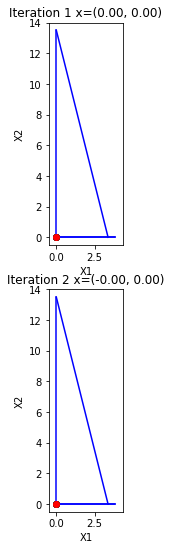

In [352]:
# Пример ненулевой начальной точки
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
ans = solve_lin_prog(A, b, c, draw=True, method=method, start_point=np.array([0, 2.5]))
corr_ans = (np.array([ 4.,  0.]), 20.0)

INITIAL PROBLEM:
[[-1.  1. -1.]
 [-1. -2. -2.]
 [ 0.  1.  1.]
 [ 2.  1.  0.]]
n=3, m=2, basis=[0 1 2], nonbasis=[3 4] with c_old=None
>             AUXILARY PROBLEM:
[[-1.  1. -1. -1.]
 [-1. -2. -1. -2.]
 [ 0.  1. -1.  1.]
 [-0. -0.  1.  0.]]
n=3, m=3, basis=[0 1 2], nonbasis=[3 4 5] with c_old=[-2 -1  0  0]
>First step
>j=2
>i=1
>basis [0 5 2], nonbasis [3 4 1]
>[[-0.  3. -1.  1.]
 [ 1.  2. -1.  2.]
 [ 1.  3. -1.  3.]
 [-1. -2.  1. -2.]]
n=3, m=3, basis=[0 5 2], nonbasis=[3 4 1] with c_old=[-2. -1.  0.  0.]
>          AUXILARY ITERATION #1
>j=1
>ratios [0.3333333333333333 1.0 1.0]
>i=0
>basis [4 5 2], nonbasis [3 0 1]
>[[-0.          0.33333333 -0.33333333  0.33333333]
 [ 1.         -0.66666667 -0.33333333  1.33333333]
 [ 1.         -1.         -0.          2.        ]
 [-1.          0.66666667  0.33333333 -1.33333333]]
n=3, m=3, basis=[4 5 2], nonbasis=[3 0 1] with c_old=[-2.          0.33333333 -0.33333333  0.33333333]
>x=[ 0.          0.33333333  1.33333333], w=[ 0.  0.  2.]
>     

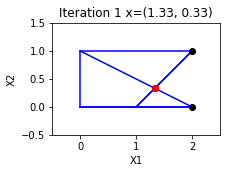

(array([ 1.33333333,  0.33333333]), -3.0000000000000004, 0)


In [353]:
# Пример инициализации
A=np.array([[-1,1],[-1, -2], [0, 1]])
b=np.array([-1, -2, 1])
c=np.array([-2, -1])
ans = solve_lin_prog(A, b, c, method='largest_coef', draw=True)
corr_ans = (np.array([ 1.33333333,  0.33333333]), -3)
print(ans)
assert((float_equal(ans[0], corr_ans[0])).all() and float_equal(ans[1], corr_ans[1]).all())

(5, 2)
INITIAL PROBLEM:
[[ -4.  -2.  -8.]
 [ -2.   0.  -2.]
 [  3.   2.  10.]
 [ -1.   3.   1.]
 [  0.  -3.  -2.]
 [  3.  -4.   0.]]
n=5, m=2, basis=[0 1 2 3 4], nonbasis=[5 6] with c_old=None
>             AUXILARY PROBLEM:
[[ -4.  -2.  -1.  -8.]
 [ -2.   0.  -1.  -2.]
 [  3.   2.  -1.  10.]
 [ -1.   3.  -1.   1.]
 [  0.  -3.  -1.  -2.]
 [ -0.  -0.   1.   0.]]
n=5, m=3, basis=[0 1 2 3 4], nonbasis=[5 6 7] with c_old=[-3  4  0  0]
>First step
>j=2
>i=0
>basis [7 1 2 3 4], nonbasis [5 6 0]
>[[  4.   2.  -1.   8.]
 [  2.   2.  -1.   6.]
 [  7.   4.  -1.  18.]
 [  3.   5.  -1.   9.]
 [  4.  -1.  -1.   6.]
 [ -4.  -2.   1.  -8.]]
n=5, m=3, basis=[7 1 2 3 4], nonbasis=[5 6 0] with c_old=[-3.  4.  0.  0.]
>          AUXILARY ITERATION #1
>j=0
>ratios [2.0 3.0 2.5714285714285716 3.0 1.5]
>i=4
>basis [7 1 2 3 5], nonbasis [4 6 0]
>[[-1.    3.   -0.    2.  ]
 [-0.5   2.5  -0.5   3.  ]
 [-1.75  5.75  0.75  7.5 ]
 [-0.75  5.75 -0.25  4.5 ]
 [ 0.25 -0.25 -0.25  1.5 ]
 [ 1.   -3.   -0.   -2.  ]]
n=

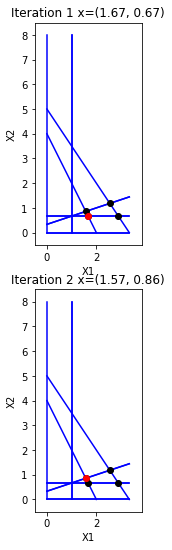

(array([ 1.57142857,  0.85714286]), -1.2857142857142856, 1)


In [354]:
# Пример инициализации
A = np.array([[-4,-2],[-2,0], [3,2],[-1,3], [0,-3]])
print(A.shape)
b = np.array([-8,-2,10,1,-2])
c = np.array([-3,4])
ans = solve_lin_prog(A, b, c, method=method, draw=True)
print(ans)
corr_ans = (np.array([ 1.57142857,  0.85714286]), -1.2857142857142856)
assert((float_equal(ans[0], corr_ans[0])).all() and float_equal(ans[1], corr_ans[1]).all())

In [355]:
# Пример неограниченной задачи
A=np.array([[-1,-1],[-2, -1]])
b=np.array([1, 2])
c=np.array([2, 1])
try:
    ans = solve_lin_prog(A, b, c, method=method, draw=True)
except Exception as e:
    print(e)


SOLVING PROBLEM:
[[-1. -1.  1.]
 [-2. -1.  2.]
 [-2. -1.  0.]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[ 1.  2.]
>          ITERATION #1
Problem is unbounded


In [356]:
# Пример недопустимой задачи
A=np.array([[1,1],[-1, -1]])
b=np.array([1, -2])
c=np.array([-2, -1])
try:
    ans = solve_lin_prog(A, b, c, method=method, draw=True)
except Exception as e:
    print(e)

INITIAL PROBLEM:
[[ 1.  1.  1.]
 [-1. -1. -2.]
 [ 2.  1.  0.]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>             AUXILARY PROBLEM:
[[ 1.  1. -1.  1.]
 [-1. -1. -1. -2.]
 [-0. -0.  1.  0.]]
n=2, m=3, basis=[0 1], nonbasis=[2 3 4] with c_old=[-2 -1  0  0]
>First step
>j=2
>i=1
>basis [0 4], nonbasis [2 3 1]
>[[ 2.  2. -1.  3.]
 [ 1.  1. -1.  2.]
 [-1. -1.  1. -2.]]
n=2, m=3, basis=[0 4], nonbasis=[2 3 1] with c_old=[-2. -1.  0.  0.]
>          AUXILARY ITERATION #1
>j=0
>ratios [1.5 2.0]
>i=0
>basis [2 4], nonbasis [0 3 1]
>[[ 0.5  1.  -0.5  1.5]
 [-0.5 -0.  -0.5  0.5]
 [ 0.5 -0.   0.5 -0.5]]
n=2, m=3, basis=[2 4], nonbasis=[0 3 1] with c_old=[ 1.  1. -1.  3.]
>x=[ 1.5  0.   0.5], w=[ 0.  0.]
Problem is infeasible


SOLVING PROBLEM:
[[ 1.   2.   5. ]
 [ 2.   0.5  8. ]
 [-5.  -1.   0. ]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[ 5.  8.]
>          ITERATION #1
>j=0
>ratios [5.0 4.0]
>i=1
>basis [0 2], nonbasis [1 3]
>[[ -0.5    1.75   1.  ]
 [  0.5    0.25   4.  ]
 [  2.5    0.25  20.  ]]
n=2, m=2, basis=[0 2], nonbasis=[1 3] with c_old=None
>x=[ 4.  0.], w=[ 1.  0.]
>FINISHED in 1 iterations
>path [array([ 0.,  0.]), array([ 4.,  0.])]
>x=[ 4.  0.], w=[ 1.  0.]
>SOLUTIONS [array([ 0.,  0.]), array([ 4.,  0.])]


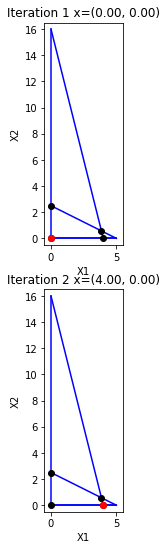

(array([ 4.,  0.]), 20.0, 1)
INITIAL PROBLEM:
[[-1.  -2.  -5. ]
 [-2.  -0.5 -1. ]
 [ 5.   8.   0. ]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>             AUXILARY PROBLEM:
[[-1.  -2.  -1.  -5. ]
 [-2.  -0.5 -1.  -1. ]
 [-0.  -0.   1.   0. ]]
n=2, m=3, basis=[0 1], nonbasis=[2 3 4] with c_old=[-5 -8  0  0]
>First step
>j=2
>i=0
>basis [4 1], nonbasis [2 3 0]
>[[ 1.   2.  -1.   5. ]
 [-1.   1.5 -1.   4. ]
 [-1.  -2.   1.  -5. ]]
n=2, m=3, basis=[4 1], nonbasis=[2 3 0] with c_old=[-5. -8.  0.  0.]
>          AUXILARY ITERATION #1
>j=1
>ratios [2.5 2.6666666666666665]
>i=0
>basis [3 1], nonbasis [2 4 0]
>[[ 0.5   0.5  -0.5   2.5 ]
 [-1.75 -0.75 -0.25  0.25]
 [-0.    1.   -0.   -0.  ]]
n=2, m=3, basis=[3 1], nonbasis=[2 4 0] with c_old=[ -1.   4.  -4.  20.]
>x=[ 0.   2.5  0. ], w=[ 0.    0.25]
[ -1.   4.  -4.  20.]
SOLVING PROBLEM:
[[  0.5   -0.5    2.5 ]
 [ -1.75  -0.25   0.25]
 [  1.     4.    20.  ]]
n=2, m=2, basis=[3 1], nonbasis=[2 0] with c_old=None
>x=[ 0.   2.5], w=[

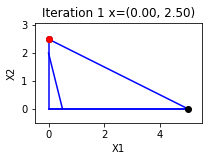

(array([ 0. ,  2.5]), -20.0, 0)
SOLVING PROBLEM:
[[ 1. -1.  1.]
 [ 2. -1.  3.]
 [ 0.  1.  5.]
 [-4. -3.  0.]]
n=3, m=2, basis=[0 1 2], nonbasis=[3 4] with c_old=None
>x=[ 0.  0.], w=[ 1.  3.  5.]
>          ITERATION #1
>j=0
>ratios [1.0 1.5 --]
>i=0
>basis [3 1 2], nonbasis [0 4]
>[[ 1. -1.  1.]
 [-2.  1.  1.]
 [-0.  1.  5.]
 [ 4. -7.  4.]]
n=3, m=2, basis=[3 1 2], nonbasis=[0 4] with c_old=None
>x=[ 1.  0.], w=[ 0.  1.  5.]
>          ITERATION #2
>j=1
>ratios [-- 1.0 5.0]
>i=1
>basis [3 4 2], nonbasis [0 1]
>[[ -1.   1.   2.]
 [ -2.   1.   1.]
 [  2.  -1.   4.]
 [-10.   7.  11.]]
n=3, m=2, basis=[3 4 2], nonbasis=[0 1] with c_old=None
>x=[ 2.  1.], w=[ 0.  0.  4.]
>          ITERATION #3
>j=0
>ratios [-- -- 2.0]
>i=2
>basis [3 4 0], nonbasis [2 1]
>[[  0.5   0.5   4. ]
 [  1.   -0.    5. ]
 [  0.5  -0.5   2. ]
 [  5.    2.   31. ]]
n=3, m=2, basis=[3 4 0], nonbasis=[2 1] with c_old=None
>x=[ 4.  5.], w=[ 2.  0.  0.]
>FINISHED in 3 iterations
>path [array([ 0.,  0.]), array([ 1.,  0.

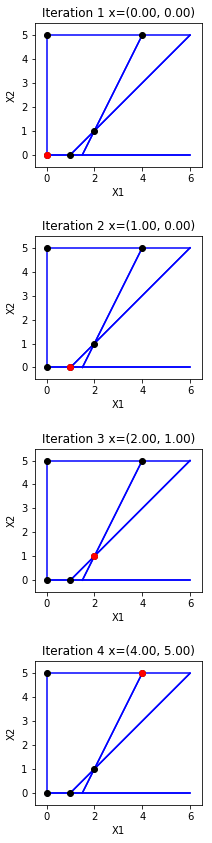

(array([ 4.,  5.]), 31.0, 3)
INITIAL PROBLEM:
[[-1. -2.  0. -4.]
 [ 1.  1. -1. -3.]
 [ 1.  3.  5.  0.]]
n=2, m=3, basis=[0 1], nonbasis=[2 3 4] with c_old=None
>             AUXILARY PROBLEM:
[[-1. -2.  0. -1. -4.]
 [ 1.  1. -1. -1. -3.]
 [-0. -0. -0.  1.  0.]]
n=2, m=4, basis=[0 1], nonbasis=[2 3 4 5] with c_old=[-1 -3 -5  0  0]
>First step
>j=3
>i=0
>basis [5 1], nonbasis [2 3 4 0]
>[[ 1.  2. -0. -1.  4.]
 [ 2.  3. -1. -1.  1.]
 [-1. -2. -0.  1. -4.]]
n=2, m=4, basis=[5 1], nonbasis=[2 3 4 0] with c_old=[-1. -3. -5.  0.  0.]
>          AUXILARY ITERATION #1
>j=1
>ratios [2.0 0.3333333333333333]
>i=1
>basis [5 3], nonbasis [2 1 4 0]
>[[-0.33333333 -0.66666667  0.66666667 -0.33333333  3.33333333]
 [ 0.66666667  0.33333333 -0.33333333 -0.33333333  0.33333333]
 [ 0.33333333  0.66666667 -0.66666667  0.33333333 -3.33333333]]
n=2, m=4, basis=[5 3], nonbasis=[2 1 4 0] with c_old=[ 1.  1. -6. -1.  1.]
>x=[ 0.          0.33333333  0.          3.33333333], w=[ 0.  0.]
>          AUXILARY ITERAT

In [357]:
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
ans = solve_lin_prog(A, b, c, draw=True, method=method)
print(ans)
corr_ans = (np.array([ 4.,  0.]), 20.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=True)
    print(ans)
    corr_ans = (np.array([ 0. ,  2.5]), -20.0, 0)
    assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)

A=np.array([[1,-1],[2,-1], [0, 1]])
b=np.array([1,3,5])
c=np.array([4,3])
ans = solve_lin_prog(A, b, c, draw=True, method=method)
print(ans)
corr_ans = (np.array([ 4.,  5.]), 31.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=True)
    print(ans)
    #corr_ans = (array([ 0. ,  2.5]), -20.0, 0)
    #assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)
#print(is_optimal(A,b,c,x))

A=np.array([[2,3,1],[4,1,2],[3,4,2]])
b=np.array([5, 11, 8])
c=np.array([5, 4, 3])
ans = solve_lin_prog(A, b, c, method=method)
print(ans)
corr_ans = (np.array([ 2.,  0.,  1.]), 13.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=False)
    print(ans)
    #corr_ans = (array([ 0. ,  2.5]), -20.0, 0)
    #assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)

A=np.array([[1,1,1,1],[2,1,-1,-1],[0,-1,0,1]])
b=np.array([40, 10, 10])
c=np.array([0.5, 3,1,4])
ans = solve_lin_prog(A, b, c, method=method)
print(ans)
corr_ans = (np.array([  0.,  15.,   0.,  25.]), 145.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=False)
    print(ans)
    corr_ans = (np.array([ 3.5,  0. ,  0.5]), -145.0, 1)
    assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)

In [92]:
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)

NameError: name 'x' is not defined

In [ ]:

# c = np.array([1, -1])
# A = np.array([[-2, 1],
#               [1, -2],
#                [1, 1]])
# b = np.array([2, 2, 5])
# x = np.array([1,4])
# x = np.array([4,1])


def is_optimal (A,b,c, x):
    """
    Здесь должна быть реализована проверка оптимальности точки. 
    Алгоритм должен работать для фиксированных n,m за константное время
    """
    # Если точка недопустима, она не оптимальна
    if (A@x>b).any() or (x < 0).any():
        return False
    A_ = -A.T
    c_ = -b
    b_ = -c
    print(A_, b_, c_)
    not_zeros_in_dual = (A@x == b)
    print(A_[:,not_zeros_in_dual])
    x_nonzero = np.linalg.solve(A_[:,not_zeros_in_dual], b_)
    print(x_nonzero)
    
    
    x_ = np.zeros(A_.shape[1])
    x_[not_zeros_in_dual] = x_nonzero
    print(x_)
    # Если для двойственной задачи её точка недопустима, то у прямой точка была не оптимальной.
    if (A_@x_ > b_).any() or (x_ < 0).any():
        return False
    
    return True

In [ ]:
is_optimal(A,b,c,x)

# ==========================================================
# Задача на МНК (0.4 балла)

* Для `method=0` решается обычным образом: $x = (A^TA)^{-1}A^Tb$ (было на лекции, нет смысла объяснять).
Здесь $A = 
\begin{pmatrix}
\dots\\
\sin t_i & t_i & 1\\
\dots 
\end{pmatrix}$
 
Для всех $i$ записывается $(a_2\sin t_i, a_1 t_i, a_0)$ как $A \cdot \begin{pmatrix}a_2\\a_1\\a_0\end{pmatrix}$

* Для `method=1` сведём к задаче линейного программирования:
$\sum_i |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \rightarrow \min $

$\Leftrightarrow
\begin{cases}
    |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \le y_i^{err} \forall i\\
    \sum y_i^{err} \rightarrow \min
 \end{cases}$, где $y_i^{err}$ -- число, обозначающее ошибку по данной координате
 
$\Leftrightarrow 
 \begin{cases}
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \le y_i^{err} \forall i\\
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \ge -y_i^{err} \forall i\\
    \sum y_i^{err} \rightarrow \min
 \end{cases}$

Тогда задача сводится к
$c^Tx \rightarrow \min\\
\begin{pmatrix}
-E & A\\
-E & -A
\end{pmatrix} x \le \begin{pmatrix}y^{corr}\\-y^{corr} \end{pmatrix}$

где $x = (y^{err}_1,\dots,y^{err}_n,a_2,a_1,a_0), c = (1, \dots, 1, 0, 0, 0)$.

Наша реализация симплекс-метода максимизирует, поэтому домножим $c$ на $-1$.

* Для `method=2`:
$\max_i |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \rightarrow \min $
$\Leftrightarrow 
 \begin{cases}
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \le y^{err} \forall i\\
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \ge -y^{err} \forall i\\
    y^{err} \rightarrow \min
 \end{cases}$
 
$\Leftrightarrow$ (для такой же A)

$c^Tx \rightarrow \min\\
\begin{pmatrix}
\begin{pmatrix}-1\\ \vdots \\ -1 \end{pmatrix} & A\\
\begin{pmatrix}-1\\ \vdots \\ -1 \end{pmatrix} & -A
\end{pmatrix} x \le \begin{pmatrix}y^{corr}\\-y^{corr} \end{pmatrix}$

где $x = (y^{err},a_2,a_1,a_0), c = (1, 0, 0, 0)$

In [444]:
from math import sin
import numpy as np

"""Пусть физический закон описывается зависимостью 
некоторого измеряемого значения y(x, a) 
от времени и координаты x при параметрах a:"""
def y(t,a): 
    return a[2]*sin(t)+a[1]*t +a[0]

def y_vector(t, a):
    return [y(t_, a) for t_ in t]

"""
Дан набор координат t размера m, значения распределены равномерно). Пусть m = 200.
"""
m = 200
t=[i*10.0/m for i in range(m)]


"""Для каждого момента времени t сгенерируйте соответствующее 
значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера: """
a=[10,100,1000]

def get_y (a, σ):
    """Результаты измерений отличаются от истинных значений в силу действия случайной аддитивной помехи 
    (случайность подчиняется нормальному закону распределения N(0, σ))"""
    y_real=np.array([y(i,a) for i in t])
    y_corr=y_real+np.random.normal(0,σ,m)
    return y_real, y_corr

#todo -выбрать параметр
#σ=0.5
σ=200

# генерация значений. изначальные и с помехами
y_real, y_corr= get_y(a,σ)

def solve_overdefined_system(A, b, method=0):
    A = np.matrix(A)
    b = b
    if method == 0:
        return ((A.T@A).I @ A.T @ b).A1
    elif method == 1:
        E = np.eye(A.shape[0])
        A_ = np.bmat([[-E, A],
                      [-E, -A]])
        
        b_ = np.hstack([b, -b])
        c_ = -np.hstack([np.ones(A.shape[0]), np.zeros(A.shape[1])]) # Точно с минусом?
        #print(A.shape, A_.shape, b_.shape, c_.shape)
        x, _, _ = solve_lin_prog(A_, b_, c_)
        #x = linprog(-c_, A_ub=A_, b_ub=b_, options=dict(bland=True, tol=1e-8, maxiter=10 ** 6))
        #print(x)
        return x.x[-A.shape[1]:]
    elif method == 2:
        ones = np.ones(A.shape[0]).reshape(-1,1)
        A_ = np.bmat([[-ones, A],
                      [-ones, -A]])
        b_ = np.hstack([b, -b])
        c_ = -np.hstack([[1], np.zeros(A.shape[1])])
        #print(A.shape, A_.shape, b_.shape, c_.shape)
        
        #x, _, _ = solve_lin_prog(ST, b, c)
        x = linprog(-c_, A_ub=A_, b_ub=b_, options=dict(bland=True, tol=1e-8, maxiter=10 ** 6))
        #print(x)
        return x.x[-A.shape[1]:]

# Я решил вынести функцию наружу для большей универсальности.
def get_params (y_corr, t, func, method=0):
    """
    По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    •	method=0 -> сумма квадратов невязок будет минимальна.
    •	method=1 -> сумма абсолютных значений невязок будет минимальна.
    •	method=2 -> максимальное абсолютное значение невязки будет минимально.
    
    #todo - написать ф-ю
    """
    A = np.matrix([func(t_) for t_ in t])
    return solve_overdefined_system(A, y_corr, method=method)


## Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

In [445]:
def analyze_approximation(t, y_corr):
    plt.figure(figsize=(10, 5))
    plt.plot(t, y_vector(t, a), color='black')
    plt.scatter(t, y_corr, color='gray', alpha=0.5)
    
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)], method=0)
    print('For method=0', a_est)
    plt.plot(t, y_vector(t, a_est), color='r', label='For method=0')
    
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)], method=1)
    print('For method=1', a_est)
    plt.plot(t, y_vector(t, a_est), color='g', label='For method=1')
    
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)], method=2)
    print('For method=2', a_est)
    plt.plot(t, y_vector(t, a_est), color='b', label='For method=2')
    
    plt.legend()
    plt.ylim(-2000, 2000)
    plt.show()

For method=0 [  -2.89365042  101.37634657  959.55309437]
INITIAL PROBLEM:
[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00  -3.65618444e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   5.00000000e-02
    4.99791693e-02  -1.81809881e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.00000000e-01
    9.98334166e-02   1.59050579e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.90000000e+00
    4.57535894e-01  -6.91847048e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.95000000e+00
    5.01405128e-01  -4.63983514e+02]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
n=400, m=203, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  5

IndexError: index 203 is out of bounds for axis 0 with size 1

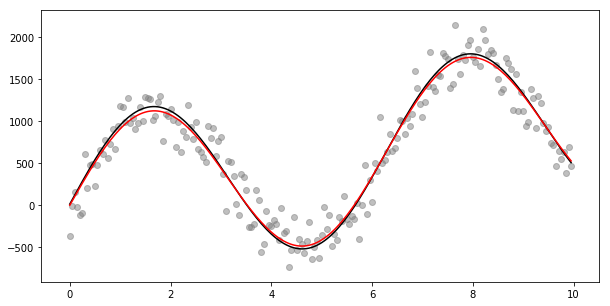

In [446]:
analyze_approximation(t, y_corr)

For method=0 [  303.28184179    34.51097948  1046.79727836]
For method=1 [   10.62911474    93.57337097  1023.39914864]
For method=2 [ 1877.80351569     0.          7070.71502345]


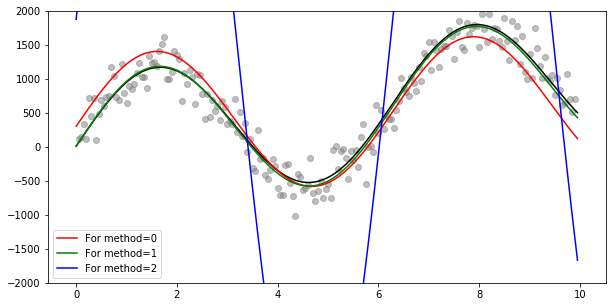

In [425]:
y_corr_with_outlier = y_corr.copy()
outlier = 10000
y_corr_with_outlier[0] += outlier
y_corr_with_outlier[-1] -= outlier

analyze_approximation(t, y_corr_with_outlier)

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?

In [431]:
A = np.random.normal(size=(200, 80))
b = np.random.normal(size=(200))

x0 = solve_overdefined_system(A, b, method=0)
x1 = solve_overdefined_system(A, b, method=1)
x2 = solve_overdefined_system(A, b, method=2)

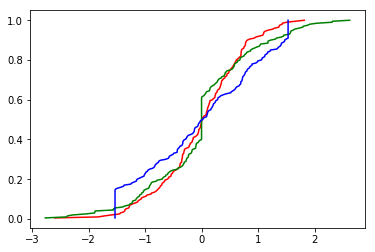

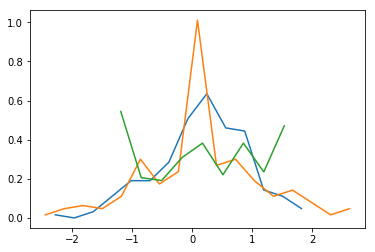

In [440]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

plt.figure()
plt.plot(*ecdf(b-A@x0), color='r', label='For method=0')
plt.plot(*ecdf(b-A@x1), color='g', label='For method=1')
plt.plot(*ecdf(b-A@x2), color='b', label='For method=2')
plt.show()

plt.figure()
counts, bin_edges = np.histogram(b-A@x0, bins='auto', density=True)
plt.plot(bin_edges[1:], counts)
counts, bin_edges = np.histogram(b-A@x1, bins='auto', density=True)
plt.plot(bin_edges[1:], counts)
counts, bin_edges = np.histogram(b-A@x2, bins='auto', density=True)
plt.plot(bin_edges[1:], counts)
plt.show()

## Бонус +1 Балл
Напишите программу которая для обоих методов из задачи 5 будет использовать 2^n-1 итераций (бонус за каждый метод) и напишите обоснование (итого 0.5 балла за каждый метод)

Лексикографический метод влияет только на выбор выходящей переменной. Выбор входящей же может осуществляться любым методом, в том числе методом наибольшего коэффициента. Для него известен простой пример, для которого время работы $2^n-1$ — деформированный гиперкуб Кли-Минти. Там будут обязательно обойдены все вершины.

Он строится так:


In [447]:
def generate_killer_sequence(n, method='blend'):
    if method=='blend':
        A1 = np.eye(n)
        for i in range(0, n-1):
            A1[i+1, i] = 1/3
        b1 = np.ones(n)
        A2 = -np.eye(n)
        for i in range(0, n-1):
            A2[i+1, i] = 1/3
        b2 = np.zeros(n)
        A = np.vstack([A1, A2])
        b = np.hstack([b1, b2])
        c = np.zeros(n)
        c[n-1] = 1
        print(c)
        print(A)
        print(b)
        return A, b, c
    elif method=='lexical':
        c = np.array([10**i for i in range(n, 0, -1)])
        b = np.array([100**i for i in range(0, n)])
        A = np.eye(n)
        for i in range(0, n):
            for j in range(0, i):
                A[i, j] = 2*10**(i-j)
        return A, b, c
    elif method=='blend2':
        a = 2
        c = np.array([a**i for i in range(n, 0, -1)])
        b = np.array([5*5**i for i in range(0, n)])
        A = np.eye(n)
        for i in range(0, n):
            for j in range(0, i):
                A[i, j] = 2*a**(i-j)
        return A, b, c

In [448]:
for i in range(2, 5):
    A, b, c = generate_killer_sequence(i, method='lexical')
    print(A, b, c)
    x, f, n_iter = solve_lin_prog(A, b, c, method='lexical')
    assert (2**i-1 == n_iter)

[[  1.   0.]
 [ 20.   1.]] [  1 100] [100  10]
SOLVING PROBLEM:
[[   1.    0.    1.]
 [  20.    1.  100.]
 [-100.  -10.    0.]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[   1.  100.]
>          ITERATION #1
>j=0
>ratios [1.0 5.0]
>i=0
>basis [2 1], nonbasis [0 3]
>[[   1.   -0.    1.]
 [ -20.    1.   80.]
 [ 100.  -10.  100.]]
n=2, m=2, basis=[2 1], nonbasis=[0 3] with c_old=None
>x=[ 1.  0.], w=[  0.  80.]
>          ITERATION #2
>j=1
>ratios [-- 80.0]
>i=1
>basis [2 3], nonbasis [0 1]
>[[   1.   -0.    1.]
 [ -20.    1.   80.]
 [-100.   10.  900.]]
n=2, m=2, basis=[2 3], nonbasis=[0 1] with c_old=None
>x=[  1.  80.], w=[ 0.  0.]
>          ITERATION #3
>j=0
>ratios [1.0 --]
>i=0
>basis [0 3], nonbasis [2 1]
>[[    1.    -0.     1.]
 [   20.     1.   100.]
 [  100.    10.  1000.]]
n=2, m=2, basis=[0 3], nonbasis=[2 1] with c_old=None
>x=[   0.  100.], w=[ 1.  0.]
>FINISHED in 3 iterations
>path [array([ 0.,  0.]), array([ 1.,  0.]), array([  1.,  80.]), ar

>          ITERATION #3
>j=0
>ratios [1.0 -- 41.0 491.0]
>i=0
>basis [0 5 2 3], nonbasis [4 1 6 7]
>[[  1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    1.00000000e+00]
 [  2.00000000e+01   1.00000000e+00  -0.00000000e+00  -0.00000000e+00
    1.00000000e+02]
 [ -2.00000000e+02  -2.00000000e+01   1.00000000e+00  -0.00000000e+00
    8.00000000e+03]
 [ -2.00000000e+03  -2.00000000e+02   2.00000000e+01   1.00000000e+00
    9.80000000e+05]
 [  1.00000000e+04   1.00000000e+03  -1.00000000e+02  -1.00000000e+01
    1.00000000e+05]]
n=4, m=4, basis=[0 5 2 3], nonbasis=[4 1 6 7] with c_old=None
>x=[   0.  100.    0.    0.], w=[  1.00000000e+00   0.00000000e+00   8.00000000e+03   9.80000000e+05]
>          ITERATION #4
>j=2
>ratios [-- -- 8000.0 49000.0]
>i=2
>basis [0 5 6 3], nonbasis [4 1 2 7]
>[[  1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    1.00000000e+00]
 [  2.00000000e+01   1.00000000e+00  -0.00000000e+00  -0.00000000e+00
    1.00000000e+02]
 [

>x=[  1.00000000e+00   0.00000000e+00   0.00000000e+00   9.98000000e+05], w=[    0.    80.  9800.     0.]
>          ITERATION #15
>j=0
>ratios [0.9999999999999999 -- -- --]
>i=0
>basis [0 1 2 7], nonbasis [4 5 6 3]
>[[  1.00000000e+00  -2.77555756e-20  -2.77555756e-21  -1.38777878e-22
    1.00000000e+00]
 [  2.00000000e+01   1.00000000e+00  -2.77555756e-19  -1.38777878e-20
    1.00000000e+02]
 [  2.00000000e+02   2.00000000e+01   1.00000000e+00  -1.38777878e-18
    1.00000000e+04]
 [  2.00000000e+03   2.00000000e+02   2.00000000e+01   1.00000000e+00
    1.00000000e+06]
 [  1.00000000e+04   1.00000000e+03   1.00000000e+02   1.00000000e+01
    1.00000000e+07]]
n=4, m=4, basis=[0 1 2 7], nonbasis=[4 5 6 3] with c_old=None
>x=[      0.       0.       0. 1000000.], w=[  1.00000000e+00   1.00000000e+02   1.00000000e+04   0.00000000e+00]
>FINISHED in 15 iterations
>path [array([ 0.,  0.,  0.,  0.]), array([ 1.,  0.,  0.,  0.]), array([  1.,  80.,   0.,   0.]), array([   0.,  100.,    0.,    

In [449]:
for i in range(2, 5):
    A, b, c = generate_killer_sequence(i, method='blend2')
    print(A, b, c)
    x, f, n_iter = solve_lin_prog(A, b, c, method='blend')
    assert (2**i-1 == n_iter)

[[ 1.  0.]
 [ 4.  1.]] [ 5 25] [4 2]
SOLVING PROBLEM:
[[  1.   0.   5.]
 [  4.   1.  25.]
 [ -4.  -2.   0.]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[  5.  25.]
>          ITERATION #1
>j=0
>ratios [5.0 6.25]
>i=0
>basis [2 1], nonbasis [0 3]
>[[  1.  -0.   5.]
 [ -4.   1.   5.]
 [  4.  -2.  20.]]
n=2, m=2, basis=[2 1], nonbasis=[0 3] with c_old=None
>x=[ 5.  0.], w=[ 0.  5.]
>          ITERATION #2
>j=1
>ratios [-- 5.0]
>i=1
>basis [2 3], nonbasis [0 1]
>[[  1.  -0.   5.]
 [ -4.   1.   5.]
 [ -4.   2.  30.]]
n=2, m=2, basis=[2 3], nonbasis=[0 1] with c_old=None
>x=[ 5.  5.], w=[ 0.  0.]
>          ITERATION #3
>j=0
>ratios [5.0 --]
>i=0
>basis [0 3], nonbasis [2 1]
>[[  1.  -0.   5.]
 [  4.   1.  25.]
 [  4.   2.  50.]]
n=2, m=2, basis=[0 3], nonbasis=[2 1] with c_old=None
>x=[  0.  25.], w=[ 5.  0.]
>FINISHED in 3 iterations
>path [array([ 0.,  0.]), array([ 5.,  0.]), array([ 5.,  5.]), array([  0.,  25.])]
>x=[  0.  25.], w=[ 5.  0.]
>SOLUTIONS [array(

>i=0
>basis [0 5 6 7], nonbasis [4 1 2 3]
>[[   1.   -0.   -0.   -0.    5.]
 [   4.    1.   -0.   -0.   25.]
 [  -8.   -4.    1.   -0.   25.]
 [  16.    8.   -4.    1.  325.]
 [  16.    8.   -4.    2.  950.]]
n=4, m=4, basis=[0 5 6 7], nonbasis=[4 1 2 3] with c_old=None
>x=[   0.   25.   25.  325.], w=[ 5.  0.  0.  0.]
>          ITERATION #12
>j=2
>ratios [-- -- 25.0 --]
>i=2
>basis [0 5 2 7], nonbasis [4 1 6 3]
>[[  1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    5.00000000e+00]
 [  4.00000000e+00   1.00000000e+00  -0.00000000e+00  -0.00000000e+00
    2.50000000e+01]
 [ -8.00000000e+00  -4.00000000e+00   1.00000000e+00  -0.00000000e+00
    2.50000000e+01]
 [ -1.60000000e+01  -8.00000000e+00   4.00000000e+00   1.00000000e+00
    4.25000000e+02]
 [ -1.60000000e+01  -8.00000000e+00   4.00000000e+00   2.00000000e+00
    1.05000000e+03]]
n=4, m=4, basis=[0 5 2 7], nonbasis=[4 1 6 3] with c_old=None
>x=[   0.   25.    0.  425.], w=[  5.   0.  25.   0.]
>          ITER

In [450]:
from scipy.optimize import linprog

# Avis-Chvatal example
# https://link.springer.com/chapter/10.1007/BFb0121192
a = 2
c = np.array([a**2,a,1])  # maximize
A = np.array([[1, 0, 0],
            [2*a, 1, 0],
            [2*a**2,2*a, 1]])
b = np.array([5, 25, 125])

# a = 0.1
# c = np.array([a**2,a,1])  # maximize
# A = np.array([[1, 0, 0],
#             [2*a, 1, 0],
#             [2*a**2,2*a, 1]])
# b = np.array([1, 1, 1])

# c = np.array([a,1])  # maximize
# A = np.array([[1, 0],
#             [2*a, 1]])
# b = np.array([1, 1])

print(linprog(-c, A_ub=A, b_ub=b))
solve_lin_prog(A, b, c, method='blend')

     fun: -125.0
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([  5.,  25.,   0.])
  status: 0
 success: True
       x: array([   0.,    0.,  125.])
SOLVING PROBLEM:
[[   1.    0.    0.    5.]
 [   4.    1.    0.   25.]
 [   8.    4.    1.  125.]
 [  -4.   -2.   -1.    0.]]
n=3, m=3, basis=[0 1 2], nonbasis=[3 4 5] with c_old=None
>x=[ 0.  0.  0.], w=[   5.   25.  125.]
>          ITERATION #1
>j=0
>ratios [5.0 6.25 15.625]
>i=0
>basis [3 1 2], nonbasis [0 4 5]
>[[  1.  -0.  -0.   5.]
 [ -4.   1.  -0.   5.]
 [ -8.   4.   1.  85.]
 [  4.  -2.  -1.  20.]]
n=3, m=3, basis=[3 1 2], nonbasis=[0 4 5] with c_old=None
>x=[ 5.  0.  0.], w=[  0.   5.  85.]
>          ITERATION #2
>j=1
>ratios [-- 5.0 21.25]
>i=1
>basis [3 4 2], nonbasis [0 1 5]
>[[  1.  -0.  -0.   5.]
 [ -4.   1.  -0.   5.]
 [  8.  -4.   1.  65.]
 [ -4.   2.  -1.  30.]]
n=3, m=3, basis=[3 4 2], nonbasis=[0 1 5] with c_old=None
>x=[ 5.  5.  0.], w=[  0.   0.  65.]
>          ITERATION #3
>j=0
>rati

(array([   0.,    0.,  125.]), 125.0, 7)